## Загрузка библиотек

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.utils import shuffle
#!pip install catboost
#from catboost import CatBoostClassifier
#from sklearn.model_selection import GridSearchCV
%matplotlib inline
#from sklearn.metrics import make_scorer
from google.colab import files, drive

In [50]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/chemp_orenburg/train_dataset_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/chemp_orenburg/test_dataset_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Исследовательский анализ данных

Рассмотрю отдельно признаки для визуального определения аномалий.

Рассматриваю признак с данными о времени портаченном на выполнение домашних заданий.

In [51]:
df.spent_time_to_complete_hw.value_counts()                   

 0.0    42466
-1.0        1
Name: spent_time_to_complete_hw, dtype: int64

В признаке более 70% - пропуски, все имеющиеся значения кроме одного - "0". Столбец можно удалить без потери качества датасета.

Среди клиентов кто хоть раз был лидером групповых задач, только 107 человек кто купил повторно курс. Столбец можно также удалить.


In [52]:
df[df['hw_leader']>0].query('target>0')

,id,age_indicator,month_id,student_id,program_id,carts_created_at,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,...,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,target
109,16984,32.0,10/31/2020,6442831,551,8/18/2020,75.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
132,128096,18.0,8/31/2021,7211140,84,5/9/2021,70.0,0.0,1.0,0.0,...,NaN,NaN,NaN,4.666667,3.5,NaN,NaN,NaN,NaN,1
3386,19383,16.0,11/30/2020,6713476,551,8/12/2020,13.0,0.0,2.0,0.0,...,NaN,NaN,NaN,4.715000,NaN,3.479345,NaN,NaN,NaN,2
6459,136942,8.0,8/31/2021,7178074,552,4/29/2021,9.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,2
6775,76960,3.0,5/31/2021,6917740,551,1/14/2021,5.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188675,228149,4.0,5/31/2021,7015216,910,1/18/2021,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,3.098429,NaN,NaN,NaN,2
195363,228254,17.0,5/31/2021,7023781,551,2/3/2021,93.0,0.0,1.0,0.0,...,NaN,NaN,NaN,4.715000,NaN,3.772000,NaN,NaN,NaN,1
195938,229142,38.0,5/31/2021,4923543,724,3/12/2021,83.0,0.0,1.0,0.0,...,1.0,0.0,0.0,3.772000,NaN,4.086333,NaN,NaN,NaN,5
198233,40526,NaN,2/28/2021,6824447,584,10/9/2020,NaN,NaN,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Признак "тип оплаты" считаю неинформативным, можно удалить без потери качества.

Создам новую переменную на сонове копии основного датасета с необходимыми изменениями.

In [53]:
data_clear = df.copy().drop(['hw_leader', 'spent_time_to_complete_hw', 'payment_type'], axis=1)

In [54]:
print( 'Кол-во клиентов совершивших покупку но ранее не участвовших в промо-акциях:', len(df[df['promo']=='-'].query('target>0')))
print( 'Кол-во клиентов совершивших покупку но ранее участвовших в промо-акциях:', len(df[df['promo']=='+'].query('target>0')))

Кол-во клиентов совершивших покупку но ранее не участвовших в промо-акциях: 17240
Кол-во клиентов совершивших покупку но ранее участвовших в промо-акциях: 8459


В столбце "промо" стоят символы + и - , заменим их на 1 и 0 соответсвенно

In [55]:
df.promo.unique()

array(['+', '-'], dtype=object)

In [56]:
data_clear['promo'] = data_clear['promo'].map({'+': 1, '_': 0})

Классифицирую траты клиентов заменив численные показатели. Классы создам на совнове квартилей.

In [57]:
df.price.quantile([0.25,0.5,0.75])

0.25    15391.9220
0.50    24709.4400
0.75    36415.5372
Name: price, dtype: float64

In [58]:
def pay_category(pay):
  if pay < 15000:
    return 0
  elif pay < 25000:
    return 1
  elif pay < 35000:
    return 2
  else:
    return 3

In [59]:
data_clear['price'] = df['price'].apply(pay_category)

Столбцы с признаками операционной системы, браузера, платформы удалю.

In [60]:
data_clear = data_clear.drop(['os', 'browser', 'platform'], axis=1)

Рассмотрю среднюю длительность звонка и разговора.

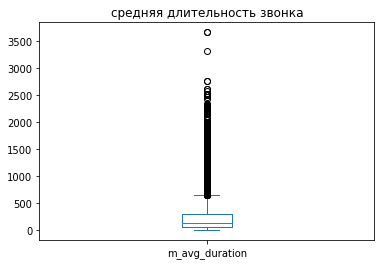

In [61]:
df.m_avg_duration.plot(kind='box', title = 'средняя длительность звонка')

In [62]:
print(
    '% людей совершивших покупку среди клиентов с аномальными значениями в признаке "средняя длительность звонка":',
    len(df[df['m_avg_duration']> 500].query('target>0')) / len(df[df['target']>0] * 100)
)

% людей совершивших покупку среди клиентов с аномальными значениями в признаке "средняя длительность звонка": 0.016265224327794855


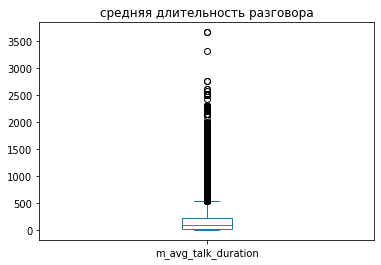

In [63]:
df.m_avg_talk_duration.plot(kind='box', title = 'средняя длительность разговора')

In [64]:
print(
    '% людей совершивших покупку среди клиентов с аномальными значениями в признаке "средняя длительность разговора":',
    len(df[df['m_avg_talk_duration']> 500].query('target>0')) / len(df[df['target']>0] * 100)
)

% людей совершивших покупку среди клиентов с аномальными значениями в признаке "средняя длительность разговора": 0.01268531849488307


In [65]:
print(
    '% людей совершивших покупку среди клиентов с аномальными значениями в признаке "средняя длительность звонка(коммуникация с телемаркетолагами)":',
    len(df[df['p_avg_duration']> 100].query('target>0')) / len(df[df['target']>0] * 100)
)

% людей совершивших покупку среди клиентов с аномальными значениями в признаке "средняя длительность звонка(коммуникация с телемаркетолагами)": 0.012918790614420795


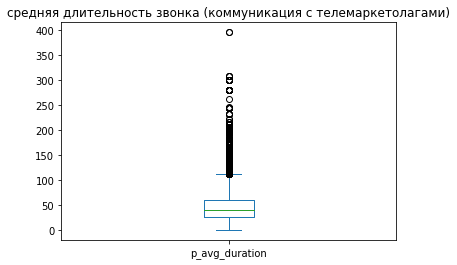

In [66]:
df.p_avg_duration.plot(kind='box', title = 'средняя длительность звонка (коммуникация с телемаркетолагами)')

Удалю строки с аномальными значениями, качество датасета не пострадает. Заменим пропуски в данных

In [67]:
data_clear = data_clear.fillna(0).query('m_avg_duration < 500 & m_avg_talk_duration <500 & p_avg_duration < 100')

Обработаю столбцы с датами

In [68]:
data_clear = data_clear.astype({'carts_created_at': 'datetime64[ns]'}).astype({'month_id': 'datetime64[ns]'})
data_clear['day_dif'] = (data_clear['month_id'] - data_clear['carts_created_at']).dt.days

In [69]:
data_clear = data_clear.drop(['month_id', 'carts_created_at'], axis = 1)

Построю графики зависимости признаков

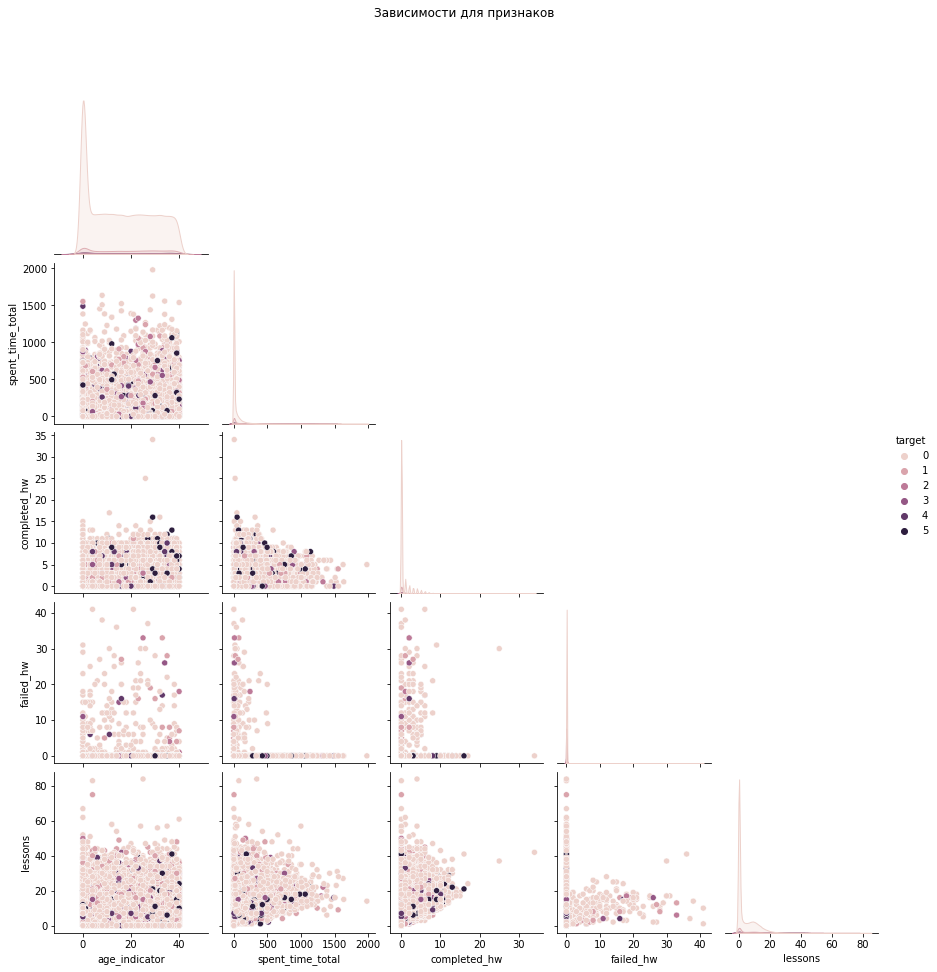

In [70]:
sns.pairplot(
data = data_clear[["target",'age_indicator', 'spent_time_total',
       'completed_hw', 'failed_hw', 'lessons']],
hue = 'target',
corner = True 
).fig.suptitle( 
'Зависимости для признаков',
y = 1.08 
);

HeatMap признаков по корреляции

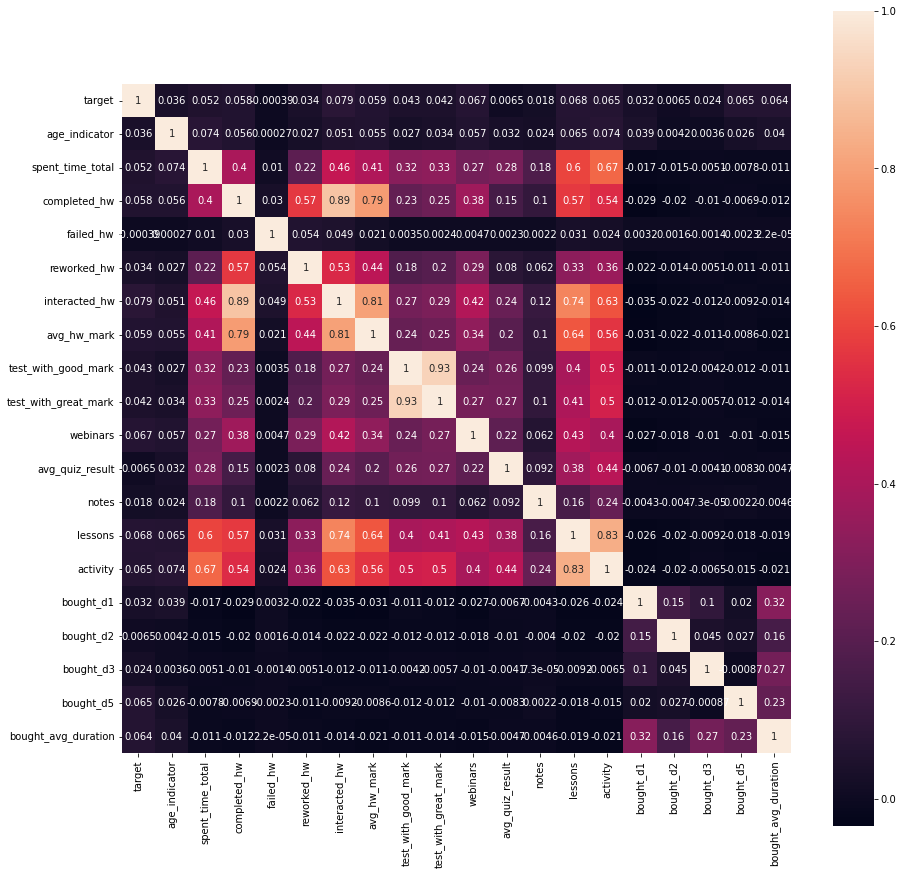

In [71]:
plt.rcParams['figure.figsize']=(15,15)

df_corr = data_clear[["target",'age_indicator', 'spent_time_total',
       'completed_hw', 'failed_hw', 'reworked_hw', 'interacted_hw',
       'avg_hw_mark', 'test_with_good_mark', 'test_with_great_mark',
       'webinars', 'avg_quiz_result', 'notes', 'lessons',
       'activity', 'bought_d1', 'bought_d2', 'bought_d3',
       'bought_d5', 'bought_avg_duration']]

g = sns.heatmap(df_corr.corr(), square = True, annot=True)

## Подготовка данных для обучения

Изучу баланс классов

In [72]:
data_clear['target'].value_counts(normalize=True)

0    0.871004
1    0.068206
4    0.018247
5    0.018221
3    0.015298
2    0.009023
Name: target, dtype: float64

Создам функцию для устранения дисбаланса классов

In [73]:
def up_dowmsample(data):
    features_zeros = data[data['target'] == 0]
    features_ones = data[data['target'] == 1]
    features_two = data[data['target'] == 2]
    features_three = data[data['target'] == 3]
    features_four = data[data['target'] == 4]
    features_five = data[data['target'] == 5]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * 7 + [features_two] * 45 + [features_three] * 35
                                    + [features_four] * 25 + [features_five] * 25
                                   )
    
    features_upsampled = shuffle(
        features_upsampled, random_state=12345)
    
    return features_upsampled

data_u_d = up_dowmsample(data_clear)

In [74]:
data_u_d['target'].value_counts(normalize=True)

0    0.272050
3    0.167238
1    0.149125
4    0.142484
5    0.142282
2    0.126820
Name: target, dtype: float64

## Выделим выборки

Поместим все столбцы object в массив, для их дальнейшего удаления

In [75]:
mass_object = data_u_d.dtypes[data_u_d.dtypes == "object"].index.values
mass_object = np.append(mass_object, "target")

In [78]:
features = data_u_d.drop(mass_object, axis = 1)
target = data_u_d[["target"]]

In [79]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)

## Обучение модели

In [80]:
m_rfc = RandomForestClassifier(random_state=0, max_depth = 50)

In [81]:
m_rfc.fit(features_train, target_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(max_depth=50, random_state=0)

## Оценка точности

In [82]:
pred = m_rfc.predict(features_test)

In [83]:
res_rf = 0.2* recall_score(target_test, pred, average='macro') + 0.8* precision_score(target_test, pred, average='macro')
print( 'Точность случайного леса:', res_rf)

Точность случайного леса: 0.9970968517550971


# test

In [84]:
df_test = test

In [85]:
df_test['price'] = df_test['price'].apply(pay_category)
df_test['promo'] = df_test['promo'].map({'+': 1, '_': 0})
df_test = df_test.astype({'carts_created_at': 'datetime64[ns]'}).astype({'month_id': 'datetime64[ns]'})
df_test['day_dif'] = (df_test['month_id'] - df_test['carts_created_at']).dt.days

In [86]:
df_test = df_test.drop(['os', 'browser', 'platform', 'carts_created_at','month_id','hw_leader', 'spent_time_to_complete_hw', 'payment_type'], axis=1)
df_test = df_test.fillna(0)
mass_object = data_u_d.dtypes[data_u_d.dtypes == "object"].index.values

In [87]:
df_test = df_test.drop(mass_object, axis = 1)

In [88]:
pred_test = m_rfc.predict(df_test)

In [89]:
result = test['id'].to_frame()

In [90]:
result['target'] = pred_test

In [91]:
result.to_csv('result_final.csv', index=False)

In [92]:
files.download('result_final.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>